https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [1]:
from DLtools.Data import instant_data,intersection,del_less_col,station_sel
from DLtools.evaluation_rec import real_eva_error,record_list_result
from DLtools.feature_sel import call_mar
from DLtools.MachineLearning import test_stationarity,tsplot

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from tqdm import tqdm

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(42)

# Loading data

In [23]:
loading = instant_data()
df,mode = loading.hourly_instant(),'hour'
# df,mode = loading.daily_instant(),'day'

if mode =='hour': n_past,n_future = 24*7,72
elif mode =='day': n_past,n_future = 60,30
else: n_future=None; print('incorrect input')

st = 'CPY012'
target,start_p,stop_p,host_path=station_sel(st,mode)
save_path =host_path+'/ARIMA/'

# NaN handle / Confirm Data


Before del col are... 337
After... 144


<AxesSubplot:xlabel='date'>

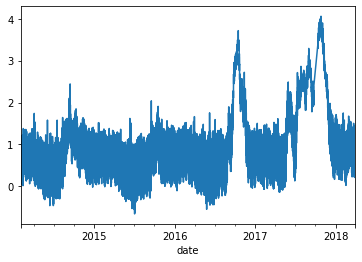

In [24]:
data = df[start_p:stop_p]
data = del_less_col(data,ratio=.85).interpolate(limit=3000000000,limit_direction='both').astype('float32')
data['Day'] = data.index.dayofyear #add day
data_uni=data[target]
data_uni.plot()

<AxesSubplot:xlabel='date'>

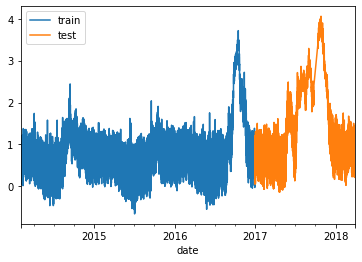

In [25]:
cut = int(len(data_uni)*.7)
train,test = data_uni.iloc[:cut],data_uni.iloc[cut:]
train.plot(label='train',legend=True)
test.plot(label='test',legend=True)

# Stationary Test

Test Statistic            -3.034547
p-value                    0.031792
Lags                      19.000000
Observations            1500.000000
Critical Value (1%)       -3.434717
Critical Value (5%)       -2.863469
Critical Value (10%)      -2.567797
dtype: float64
strong evidence against the null hypothesis(H0), reject the null hypothesis. Data has no unit root and is stationary


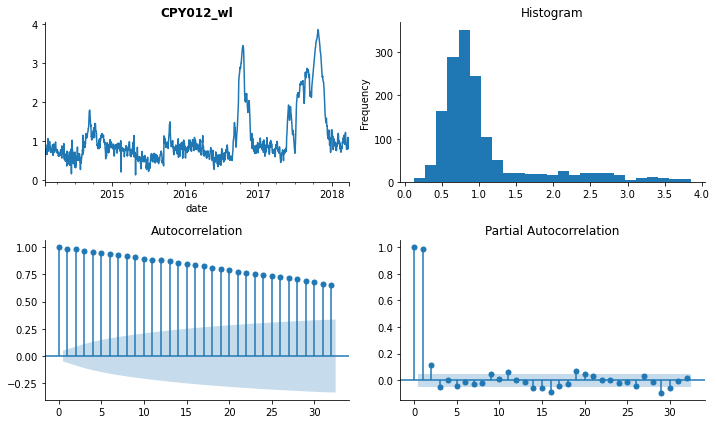

In [6]:
# Define target
tsplot(data_uni,target)
test_stationarity(data_uni)

# Auto ARIMA

In [7]:
import pmdarima as pm
from pmdarima.arima.stationarity import ADFTest

In [8]:
# Test whether we should difference at the alpha=0.05
# significance level
adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(data_uni)  # (0.01, False)
print("p value:{}, diff :{}".format(p_val,should_diff))

p value:0.21257193902141736, diff :True


In [26]:
stepwise_fit = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-41262.769, Time=2.71 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=74485.189, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.50 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=41406.036, Time=0.99 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-45496.456, Time=1.51 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-45490.251, Time=0.65 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-45533.630, Time=6.74 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-45501.219, Time=0.80 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-48505.285, Time=10.54 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-46409.849, Time=0.83 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=-48711.639, Time=11.24 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=-47236.285, Time=1.00 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=inf, Time=14.96 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=-45554.260, Time=11.94 sec
 ARIMA(5,0,1)(0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                25536
Model:               SARIMAX(5, 0, 1)   Log Likelihood               24462.934
Date:                Sun, 22 Nov 2020   AIC                         -48909.868
Time:                        22:57:36   BIC                         -48844.685
Sample:                             0   HQIC                        -48888.791
                              - 25536                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0057      0.000     15.848      0.000       0.005       0.006
ar.L1          2.3463      0.008    281.053      0.000       2.330       2.363
ar.L2         -1.7645      0.015   -119.048      0.000      -1.794      -1.735
ar.L3          0.3398      0.013     26.818      0.000       0.315       0.365
ar.L4         -0.0391      0.015     -2.618      0.009      -0.068      -0.010
ar.L5          0.1107      0.007     15.874      0.000       0.097       0.124
ma.L1         -0.8045      0.008    -96.998      0.000      -0.821      -0.788
sigma2         0.0085   4.49e-05    188.235      0.000       0.008       0.009
===================================================================================
Ljung-Box (Q):                    11441.49   Jarque-Bera (JB):            158820.36
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Get prediction for 14days/ 72 hours

In [21]:
pdq=(1,1,0)
model = ARIMA(train, order=pdq)
model_fit = model.fit(disp=0)

start_idx=len(train)
end_idx=len(train)+n_future
predictTest=model_fit.predict(start=start_idx,end=end_idx,typ='levels')

<AxesSubplot:title={'center':'mse0.030 | nse-3.476 | r20.024'}, xlabel='date'>

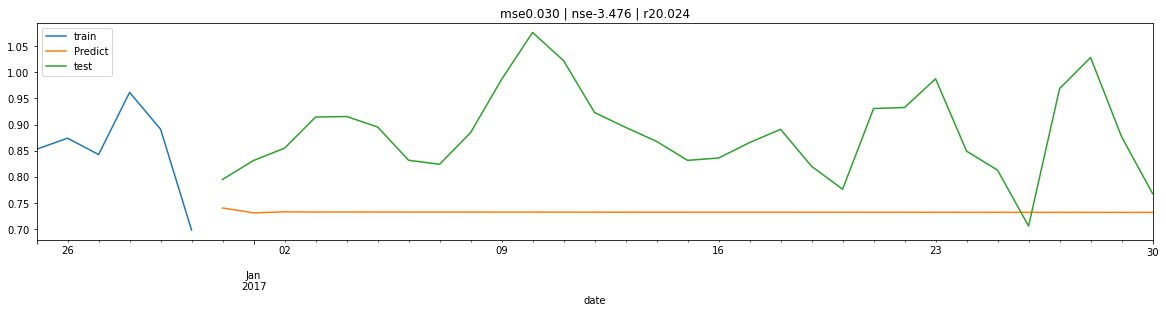

In [22]:
mse,nse,r2=real_eva_error(test[:len(predictTest)],predictTest)
plt.figure(figsize=(20,4))
plt.title("mse{:.3f} | nse{:.3f} | r2{:.3f}".format(mse,nse,r2))
train['2016-12-25':].plot(label='train',legend=True)
predictTest.plot(label='Predict',legend=True)
test[:len(predictTest)].plot(label='test',legend=True)


# ARIMA rolling in time(Code from machinery.com)

In [35]:
history = [x for x in train]
#1 predictions = pd.DataFrame()
predictions=list()
mse_l,nse_l,r2_l = list(),list(),list()
#Set pdq
pdq=(1,1,0)
for t in tqdm(range(len(test))):
    #1 history=pd.Series(history,index=data[:len(history)].index)
    model = ARIMA(history, order=pdq)
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast(steps=n_future)[0]
    
    predictions.append(yhat)   
    obs = test[t]
    history.append(obs)  

# df_out = pd.DataFrame(np.array(predictions),columns=['day'+str(i) for i in range(1,15)],index=test.index)


 31%|███▏      | 143/456 [00:03<00:07, 41.01it/s]/home/song/anaconda3/envs/tf/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
100%|██████████| 456/456 [00:11<00:00, 39.63it/s]


In [36]:
predictions=np.array(predictions)
for i in range(n_future):
    mse,nse,r2 = real_eva_error(test,predictions[i,:])
    plt.plot(test)
    plt.plot(yhat)
    plt.title('{}Water Level {} Forecast vs Actuals\n'.format(i,target)+' MSE: %.3f | NSE: %.3f | R2 score: %.3f' % (mse,nse,r2))
    plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [456, 30]

In [37]:
history = [x for x in train]
predictions = pd.DataFrame()

#Set pdq
pdq=(1,1,0)

for t in tqdm(range(len(test))):
    history=pd.Series(history,index=data[:len(history)].index)
    model = ARIMA(history, order=pdq)
    model_fit = model.fit(disp=0)

    start_idx=len(history)
    end_idx=len(history)+n_future
    yhat = model_fit.predict(start=start_idx,end=end_idx,typ='levels')
    predictions=pd.concat([predictions,yhat],axis=1)

    obs = test[t]
    history=list(history)
    history.append(obs)  



 32%|███▏      | 144/456 [00:03<00:08, 35.93it/s]/home/song/anaconda3/envs/tf/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
100%|██████████| 456/456 [00:13<00:00, 34.73it/s]


In [38]:
predictions

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-12-31,0.740253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01,0.730934,0.773647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,0.732947,0.778368,0.823365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,0.732474,0.777348,0.825174,0.849672,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,0.732546,0.777593,0.824850,0.850885,0.901466,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.97986,0.959392,0.950068,0.905159,0.808732
2018-04-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.959517,0.950187,0.905249,0.808760
2018-04-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.950307,0.905340,0.808788
2018-04-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.905430,0.808816
